<a href="https://colab.research.google.com/github/Micah-Sanders/DATS6202/blob/main/DATS6202ProjectDraft2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATS 6202 Final Paper
## Aravind Meyyappan, Micah Sanders, and Remya Raju Sulabha
## June 27th, 2024

The Oxford English Dictionary defines a task is a piece of work to be done or
undertaken. We define a skill as the operationalized knowledge to complete a task. However, skills are not uniquely linked to tasks in that multiple skills may relate to a single task, or a single task may be completed by individuals with different skills. Further, individual skills may be sufficient to complete individual tasks in ways previously unknown. In short, the relationship between skills and tasks is complex and non-static.

Traditionally, skills are represented by hierarchical taxonomies, essentially a list of differentiated skills grouped by a series of general descriptors. There are an untold
number of skills taxonomies in existence ranging from a few skill definitions to
thousands of differentiated skills. However, these taxonomies tend not to overlap well; meaning that which taxonomy you are using to define a skill will impact what the skill is defined as. This is not optimal given the plethora of different task associations possible for skills.

Our goal is to broaden the skill definitions which represent skill clusters by
combining similar skill definitions across taxonomies. Put another way, we want to identify the cluster labels from taxonomy for skill definitions from another taxonomy. We will achieve this by using a recurrent neural network trained on data from LightCast’s Open Skill Library (OSL). We will then use text analysis to apply cluster labels from LightCast to another taxonomy, the European Commission’s ESCO Classification of skill and competencies.

## Load and Clean Lightcast Data

We have stored two files on a public github repository that each represent a flat version of LightCast's OSL and ESCO's Taxonomy repsectively. These are not complete repositories, but rather a list of included skills with category and sub-category information for both. We also do some basic pre-processing to drop NAs and remove stopwords. Stopwords are "verbal fluff" added to human language text that can confound models. The keywords rarely rely on stopwords to convey information and thus removing them serves to reduce processing time without signficantly impacting meaning.

In [12]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Bidirectional, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from gensim.parsing.preprocessing import remove_stopwords

# Load and preprocess Lightcast data
url = 'https://github.com/Micah-Sanders/DATS6202/raw/main/Lightcast.csv' #Set URL
lightcast_data = pd.read_csv(url) #Read in file from URL
lightcast_data = lightcast_data[['DESCRIPTION', 'CATEGORY', 'SUBCATEGORY']].dropna() #Drop missing data
lightcast_data['DESCRIPTION'] = lightcast_data['DESCRIPTION'].astype(str).apply(remove_stopwords) #Remove stop words

# Create subcategory hybrids
lightcast_data['CATEGORY'] = lightcast_data['CATEGORY'].astype(str) + ' ' + lightcast_data['SUBCATEGORY'].astype(str)
lightcast_data = lightcast_data.drop('SUBCATEGORY', axis=1)

## Label Encoding

In [13]:
# Label encoding for categories and subcategories
category_encoder = LabelEncoder()

lightcast_data['CATEGORY_encoded'] = category_encoder.fit_transform(lightcast_data['CATEGORY'])

num_categories = lightcast_data['CATEGORY_encoded'].nunique()

## Preparing for Modeling
We next split the data into test/train dataset. We've chosen a 70/30 as a typical split distribution. This is followed by text vetorization which converts skill strings to computer readable values.

In [14]:
# Splitting the dataset into train and test sets
train_data, test_data = train_test_split(lightcast_data, test_size=0.30, random_state=42)

# Text vectorization
vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=100)
text_ds = tf.data.Dataset.from_tensor_slices(train_data['DESCRIPTION']).batch(128)
vectorizer.adapt(text_ds)

## Model Definition
???

In [15]:
# Model definition
model = Sequential([
    vectorizer,
    Embedding(10000, 128, mask_zero=True),
    Bidirectional(LSTM(128)),
    Dense(128, activation='relu'),
    Dense(num_categories, activation='softmax', name='category_output')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 100)               0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               263168    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 category_output (Dense)     (None, 274)               35346     
                                                                 
Total params: 1611410 (6.15 MB)
Trainable params: 1611

## Train Model
We now need to actually train a model. To do so, we use the training and validation data as vectorized strings. We chose 7 epochs after testing 15 epochs and finding that the var_loss accelerated at the 8th epoch indicating overfitting.

Epoch 1/7
93/93 [==============================] - 76s 676ms/step - loss: 3.8487 - accuracy: 0.4102 - val_loss: 3.4236 - val_accuracy: 0.4311
Epoch 2/7
93/93 [==============================] - 61s 658ms/step - loss: 3.3722 - accuracy: 0.4170 - val_loss: 3.3231 - val_accuracy: 0.4311
Epoch 3/7
93/93 [==============================] - 61s 653ms/step - loss: 3.0591 - accuracy: 0.4214 - val_loss: 3.3038 - val_accuracy: 0.4322
Epoch 4/7
93/93 [==============================] - 62s 668ms/step - loss: 2.6713 - accuracy: 0.4434 - val_loss: 3.3652 - val_accuracy: 0.4113
Epoch 5/7
93/93 [==============================] - 60s 642ms/step - loss: 2.3151 - accuracy: 0.4792 - val_loss: 3.4292 - val_accuracy: 0.3979
Epoch 6/7
93/93 [==============================] - 59s 635ms/step - loss: 2.0374 - accuracy: 0.5146 - val_loss: 3.5060 - val_accuracy: 0.3935
Epoch 7/7
93/93 [==============================] - 61s 660ms/step - loss: 1.7784 - accuracy: 0.5598 - val_loss: 3.8900 - val_accuracy: 0.3856


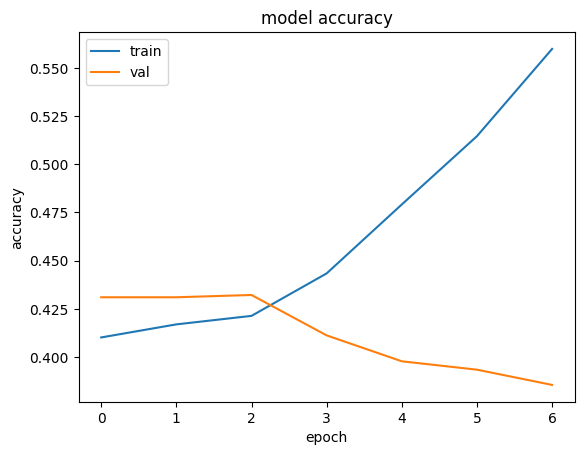

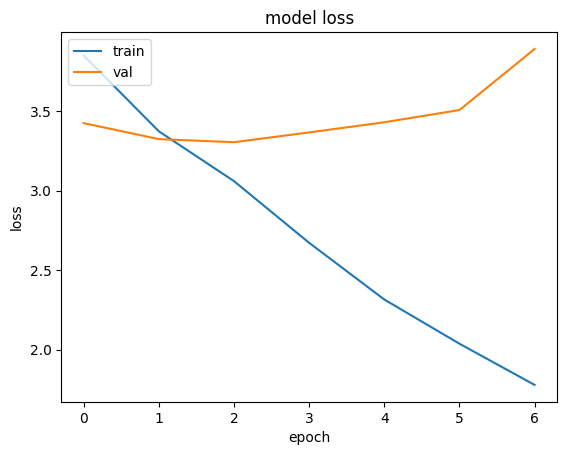

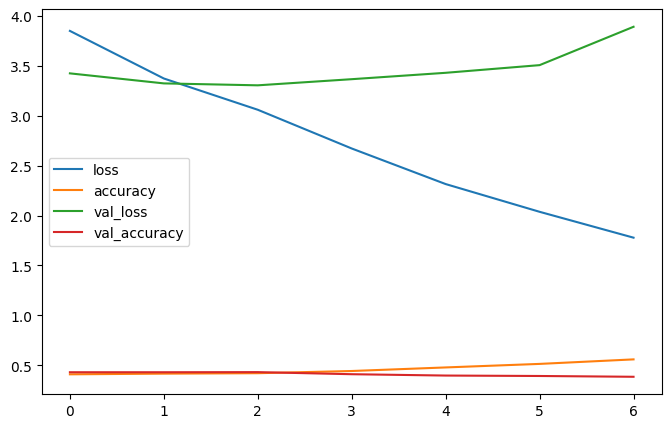

In [16]:
# Model training
history = model.fit(train_ds, epochs=7, validation_data=val_ds)

#Plot Accuracy vs. val_accuracy
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot Loss vs. val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Plot All
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

## Evaluate Model
With the model trained, we now take a look at the evaluative metrics for the training.

In [17]:
# Evaluate the model on the test set
test_results = model.evaluate(val_ds)
print(f"Test Accuracy: {test_results[1]*100:.2f}%")



40/40 [==============================] - 7s 182ms/step - loss: 3.8900 - accuracy: 0.3856
Test Accuracy: 38.56%


## Load ESCO Data
Now that we have a model, it's time to predict labels for another dataset. We are predicting labels for ESCO skills so we begin by reading in the ESCO data and vectorizing the strings. We also remove the stopwords to decrease the runtime by removing non-predicitive words.

In [ ]:
# Load and preprocess the ESCO dataset
url2 = 'https://github.com/Micah-Sanders/DATS6202/raw/main/ESCO%20skills%20Taxonomy.csv'
esco_data = pd.read_csv(url2)
esco_data = esco_data[['description']].dropna()
esco_data['description'] = esco_data['description'].astype(str).apply(remove_stopwords)

# Prepare ESCO data for prediction
esco_ds = tf.data.Dataset.from_tensor_slices(esco_data['description']).batch(64)



## Predict New ESCO Labels
We then use the trained model to predict the labels for the ESCO data. As we are tained on two layers, we need to predict two sets of labels.

In [ ]:
# Predict categories and subcategories using the trained model
predictions = model.predict(esco_ds)
predicted_categories_indices = tf.argmax(predictions['category_output'], axis=1).numpy()



## Save Results
Finally, we need to format and save results to make sure we retain the new generated labels for the ESCO data.

In [ ]:
# Convert category indices to category names
predicted_categories = category_encoder.inverse_transform(predicted_categories_indices)

# Store the results back in DataFrame for further analysis or export
esco_data['Predicted_Category'] = predicted_categories
esco_data.to_csv('ESCO_with_Predicted_Categories.csv', index=False)
print("Predicted categories and subcategories stored successfully.")

## Results
The results of this comparison are presented below in a confusion matrix.

Confusion   | True  |   False

Pred True   |    ##   | ##

Pred False  |    ##   | ##

This represents a relatively good model prediction. Here's the key stats:

Accuracy: (TP+TN)/total =

Misclassification Rate: (FP+FN)/total =

True Positive Rate: TP/actual yes =

False Positive Rate: FP/actual no =

True Negative Rate:  TN/actual no =

Precision: TP/predicted yes =

## Conclusion

We were able to produce a well trained model using LightCast data and predict the labels on ESCO data. These labels need to berified that they make some sense in the outside context. To do this, we used a typical hand coding technique by which each of the three colaborators coded a sample of 50 randomly selected skills from ESCO. These codes were then combined using a majority opinion to create a reference label. We then compared this reference label to the predicted label.